In [350]:
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [351]:
conn = pymysql.connect(host='localhost',port=int(3307), user='root', password='docker',db='foodmart')

query_sales="""
select * from sales_fact_1998
"""
df_sales=pd.read_sql(query_sales, con=conn)

/tmp/ipykernel_2188292/3930765474.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales=pd.read_sql(query_sales, con=conn)


In [352]:
# df_sales=df_sales[df_sales['promotion_id'] == 0]
df_sales.head()

,product_id,time_id,customer_id,promotion_id,store_id,store_sales,store_cost,unit_sales
0,173,748,2094,54,1,4.29,1.8447,3.0
1,1119,748,2094,54,1,9.51,3.5187,3.0
2,1242,748,2094,54,1,7.92,2.8512,4.0
3,460,748,2094,54,1,6.44,2.7048,4.0
4,104,748,2094,54,1,11.67,3.9678,3.0


In [353]:
df_sales['recency']=df_sales['time_id'].max()-df_sales['time_id']+1
df_sales=df_sales[['product_id','customer_id','store_sales','recency','time_id']]
df_sales.head()

,product_id,customer_id,store_sales,recency,time_id
0,173,2094,4.29,318,748
1,1119,2094,9.51,318,748
2,1242,2094,7.92,318,748
3,460,2094,6.44,318,748
4,104,2094,11.67,318,748


In [354]:
sales=df_sales.groupby('customer_id').agg(
    frequency=('time_id', 'nunique'),
    monetary=('store_sales','sum'),
    recency=('recency', 'min')
)
sales.head()

,frequency,monetary,recency
customer_id,,,
3,2,104.63,228
6,2,46.98,159
8,10,259.14,4
9,2,89.58,53
10,4,109.17,171


In [355]:
sales['f_score']=pd.cut(sales['frequency'], 5, labels=[1, 2, 3, 4, 5])
sales['r_score']=pd.cut(sales['recency'], 5, labels=[5, 4, 3, 2, 1])
sales['m_score']=pd.cut(sales['monetary'], 5, labels=[1, 2, 3, 4, 5])
sales['customer_value']=sales['f_score'].astype(int) * 3 + sales['m_score'].astype(int) * 2 + sales['r_score'].astype(int) * 5
sales.head()

,frequency,monetary,recency,f_score,r_score,m_score,customer_value
customer_id,,,,,,,
3,2,104.63,228,1,2,1,15
6,2,46.98,159,1,3,1,20
8,10,259.14,4,2,5,1,33
9,2,89.58,53,1,5,1,30
10,4,109.17,171,1,3,1,20


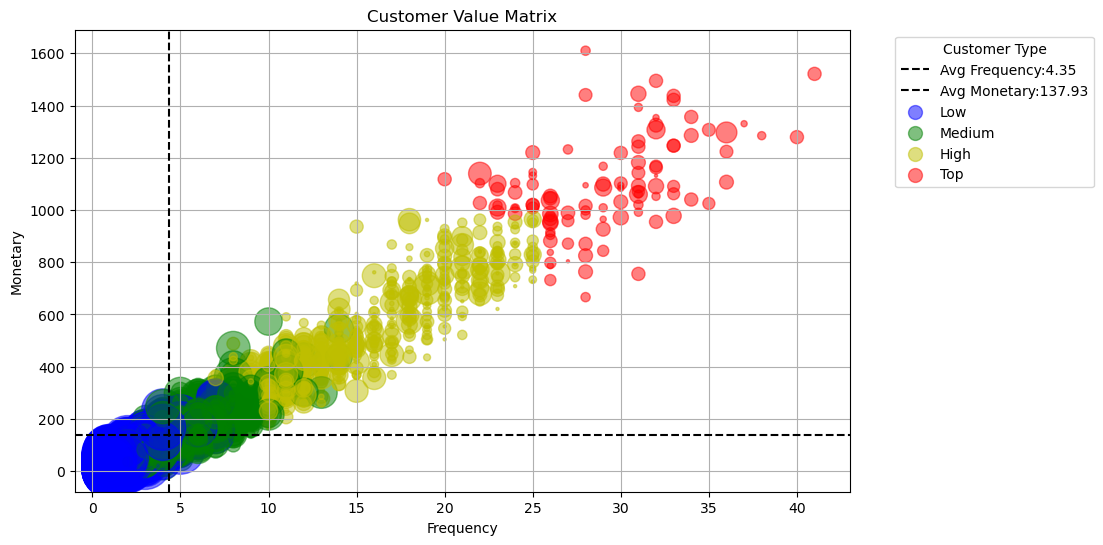

In [356]:
sales['type'] = pd.cut(sales['customer_value'], 4, labels=['Low','Medium','High','Top'])

colors_map = {'Low':'b', 'Medium':'g','High':'y','Top':'r'}
colors = sales['type'].map(colors_map)

plt.figure(figsize=(10,6))
bubble_size = sales['recency'] * 5
plt.scatter(sales['frequency'], sales['monetary'], s=bubble_size, alpha=0.5, c=colors)

avg_f = sales['frequency'].mean()
avg_m = sales['monetary'].mean()

plt.axvline(avg_f, color='black', linestyle='--', linewidth=1.5, label=f'Avg Frequency:{avg_f:.2f}')
plt.axhline(avg_m, color='black', linestyle='--', linewidth=1.5, label=f'Avg Monetary:{avg_m:.2f}')

plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Value Matrix')
plt.grid(True)

for t in colors_map:
    plt.scatter([],[], color=colors_map[t], label=t, alpha=0.5, s=100)

plt.legend(title='Customer Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [357]:
query_customer="select * from customer"
customer=pd.read_sql(query_customer, con=conn)
customer = customer[['customer_id','country','gender','total_children','education','member_card']]
customer.shape

/tmp/ipykernel_2188292/2019356427.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer=pd.read_sql(query_customer, con=conn)


(10281, 6)

In [358]:
query_product="select product_id, product_name, product_class_id from product"
product = pd.read_sql(query_product, con=conn)

query_product_class = "select * from product_class"
product_class = pd.read_sql(query_product_class, con=conn)

/tmp/ipykernel_2188292/1951810854.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  product = pd.read_sql(query_product, con=conn)
/tmp/ipykernel_2188292/1951810854.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  product_class = pd.read_sql(query_product_class, con=conn)


In [359]:
data = pd.merge(sales, customer, on='customer_id', how='inner')
data.head()

,customer_id,frequency,monetary,recency,f_score,r_score,m_score,customer_value,type,country,gender,total_children,education,member_card
0,3,2,104.63,228,1,2,1,15,Low,USA,F,1,Bachelors Degree,Bronze
1,6,2,46.98,159,1,3,1,20,Low,USA,F,3,Bachelors Degree,Bronze
2,8,10,259.14,4,2,5,1,33,High,Mexico,M,2,Bachelors Degree,Bronze
3,9,2,89.58,53,1,5,1,30,Medium,Canada,M,5,Partial High School,Normal
4,10,4,109.17,171,1,3,1,20,Low,USA,M,4,Bachelors Degree,Golden


In [360]:
data['type'].value_counts()

type
Medium    4858
Low       2158
High       702
Top        106
Name: count, dtype: int64

In [361]:
df_sales = pd.merge(df_sales, product, on='product_id', how='inner')
df_sales = pd.merge(df_sales, product_class, on='product_class_id', how='inner')
df_sales.head()

,product_id,customer_id,store_sales,recency,time_id,product_name,product_class_id,product_subcategory,product_category,product_department,product_family
0,173,2094,4.29,318,748,High Top Asparagus,61,Fresh Vegetables,Vegetables,Produce,Food
1,173,5606,4.29,24,1042,High Top Asparagus,61,Fresh Vegetables,Vegetables,Produce,Food
2,173,3884,2.86,104,962,High Top Asparagus,61,Fresh Vegetables,Vegetables,Produce,Food
3,173,230,1.43,12,1054,High Top Asparagus,61,Fresh Vegetables,Vegetables,Produce,Food
4,173,905,7.15,207,859,High Top Asparagus,61,Fresh Vegetables,Vegetables,Produce,Food


In [362]:
df_sales = pd.merge(data, df_sales, on='customer_id', how='inner')
# 高价值用户
df_sales = df_sales.loc[(df_sales['type'] == 'High')]

In [363]:
# 使用value_counts()对Product列进行分类统计
#category_counts = df_sales['product_name'].value_counts().reset_index()
#category_counts.columns = ['product_name', 'Count']

# 按照分类统计结果创建新的DataFrame
#category_counts_df = pd.DataFrame(category_counts)

# 将分类统计结果保存到本地文件，比如CSV格式
# category_counts_df.to_csv('product_counts.csv', index=False)

In [364]:
df_sales['order_id']=df_sales['time_id'].astype(str)+'-'+df_sales['customer_id'].astype(str)

# 将数据转换为事务列表，并过滤掉包含少于两个商品的事务
transactions = df_sales.groupby('order_id')['product_category'].unique().apply(list).tolist()
transactions = [transaction for transaction in transactions if len(transaction) >= 2]

len(transactions)

9422

In [365]:
te = TransactionEncoder()
tx_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(tx_ary, columns=te.columns_)
df

,Baking Goods,Bathroom Products,Beer and Wine,Bread,Breakfast Foods,Candles,Candy,Canned Anchovies,Canned Clams,Canned Oysters,...,Paper Products,Pizza,Plastic Products,Pure Juice Beverages,Seafood,Side Dishes,Snack Foods,Specialty,Starchy Foods,Vegetables
0,False,False,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,True,False,True,False,...,True,False,False,False,False,False,True,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9417,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9418,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
9419,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
9420,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


In [366]:
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True, low_memory=True)
frequent_itemsets

,support,itemsets
0,0.163978,(Baking Goods)
1,0.129484,(Bathroom Products)
2,0.132244,(Beer and Wine)
3,0.145192,(Bread)
4,0.159733,(Breakfast Foods)
...,...,...
646,0.019104,"(Meat, Snack Foods, Vegetables, Dairy)"
647,0.010401,"(Paper Products, Vegetables, Dairy, Snack Foods)"
648,0.013797,"(Snack Foods, Fruit, Vegetables, Jams and Jell..."
649,0.015708,"(Meat, Snack Foods, Fruit, Vegetables)"


In [368]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Beer and Wine),(Vegetables),0.132244,0.473254,0.067820,0.512841,1.083649,0.005235,1.081261,0.088955
1,(Candy),(Vegetables),0.129696,0.473254,0.066440,0.512275,1.082452,0.005061,1.080006,0.087523
2,(Canned Anchovies),(Vegetables),0.018467,0.473254,0.010401,0.563218,1.190097,0.001661,1.205971,0.162738
3,(Canned Oysters),(Vegetables),0.018467,0.473254,0.010189,0.551724,1.165810,0.001449,1.175049,0.144903
4,(Canned Soup),(Vegetables),0.152622,0.473254,0.078009,0.511127,1.080026,0.005780,1.077469,0.087442
...,...,...,...,...,...,...,...,...,...,...
255,"(Snack Foods, Paper Products, Dairy)",(Vegetables),0.018680,0.473254,0.010401,0.556818,1.176573,0.001561,1.188555,0.152931
256,"(Snack Foods, Fruit, Jams and Jellies)",(Vegetables),0.026215,0.473254,0.013797,0.526316,1.112121,0.001391,1.112019,0.103531
257,"(Snack Foods, Fruit, Meat)",(Vegetables),0.027701,0.473254,0.015708,0.567050,1.198193,0.002598,1.216643,0.170123
258,"(Snack Foods, Meat, Jams and Jellies)",(Vegetables),0.024835,0.473254,0.013904,0.559829,1.182936,0.002150,1.196685,0.158584
